In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


## Build Composite library

In [10]:
from utils.library.composite_library import *
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]
    
extra_functions = [
    lambda data: active_strain_decomposition_mesh(data, key='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'm_ij']),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_full', 'E_passive', 'E_active']),
    lambda data: add_static_sources_mesh(data, couple='m_ij'),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
    lambda data: material_derivative_terms(data, key='m_ij'),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/mesh_dynamics_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries, filename='mesh_derivative_library.h5')
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=7)
            library_to_tangent_space(group, libraries)
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Learn Myosin model

In [11]:
import pickle as pk
from utils.modeling.sindy_utils import *

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
key = 'm_ij'

info = dict(
    key=key,
    tmin=-5, tmax=15,
    threshold=1e-2,
    alpha=1e1,
    n_models=5,
    subset_fraction=.2,
    overleaf_only=False,
    collect_function=collect_mesh_data,
)

with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    sindy = fit_sindy_model(h5f, **info)

  0%|          | 0/12 [00:00<?, ?it/s]

D_t m_ij = 0.015 Static_DV Tr(m_ij) + -0.003 c Static_DV Tr(m_ij) + -0.075 c m_ij + 0.509 c m_ij Tr(m_ij) + 0.087 m_ij + -0.430 m_ij Tr(m_ij)


## Predict using learned model

Initializing
Loaded mesh gradient operators
Using scipy solve_ivp
Done


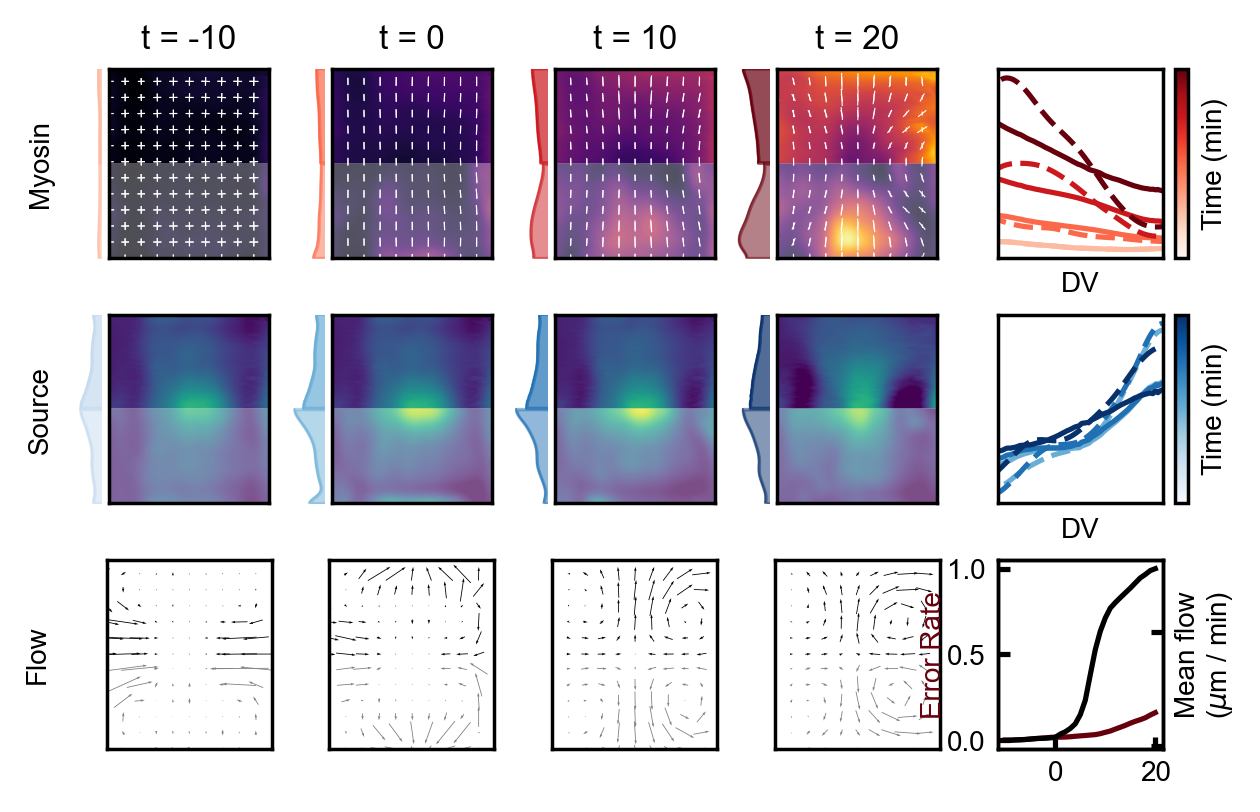

In [9]:
from utils.geometry.closed_loop import ClosedLoopMesh

class FittedModel(ClosedLoopMesh):
    def rhs(self, m, s, v, E):
        E_a = self.active.transform(E, m)
        E_p = E - E_a
        trm = self.einsum_('kkv->v', m)
        trE = self.einsum_('kkv->v', E)
        mE  = self.einsum_('ikv,kjv->ijv', m, E_p)
        mE += self.einsum_('ikv,kjv->ijv', E_p, m)
        
        #rhs  = (0.050 - 0.027 * s) * m
        #rhs += (0.014 - 0.003 * s) * self.gamma_dv_ * trm
        #rhs += 0.398 * s * m * np.einsum('kkv->v', E_a)
        
        rhs  = (0.087 - 0.075 * s) * m
        rhs += (0.015 - 0.003 * s) * self.gamma_dv_ * trm
        rhs -= (0.430 - 0.509 * s) * m * trm
                
        return rhs

from scipy.interpolate import interp1d

from utils.geometry.geometry_utils import MeshInterpolator
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.forecasting.plot_utils import *

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    s0 = LeftRightSymmetrize().fit_transform(s0)
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

#Using a flow field interpolator in the loop instead of a neural network
mesh_int = MeshInterpolator().fit(None)

v_verts = np.stack([mesh_int.transform(v0[i, ..., 10:-10]) for i in range(len(v0))])
v_int = interp1d(t0, v_verts, axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    mesh_int.transform(m0[0]).reshape([4, 1797]),
    mesh_int.transform(s0[0]).reshape([1, 1797])
])

model = FittedModel(v_model=v_model, sigma=.5)
m, s, v = model.integrate(y0, t0)
print('Done')

m = np.stack([mesh_int.inverse_transform(m[i]) for i in range(len(m))])
s = np.stack([mesh_int.inverse_transform(s[i]) for i in range(len(s))])
v = np.stack([mesh_int.inverse_transform(v[i]) for i in range(len(v))])

comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)


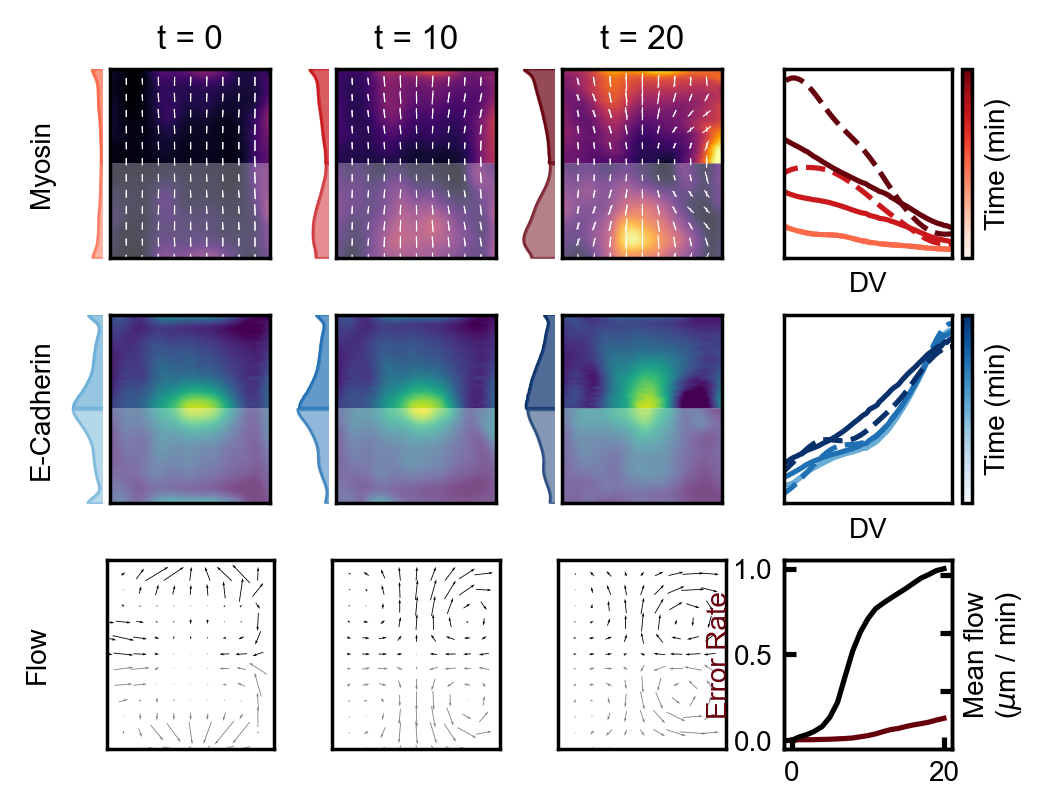

In [8]:
from utils.forecasting.plot_utils import *
comparison_plot(t0,
                ('Myosin', m, m0),
                ('E-Cadherin', s, s0),
                ('Flow', v, v0),
                dt=10)
plt.savefig('Figures/Figure3/mesh_forecasting.svg', bbox_inches='tight')

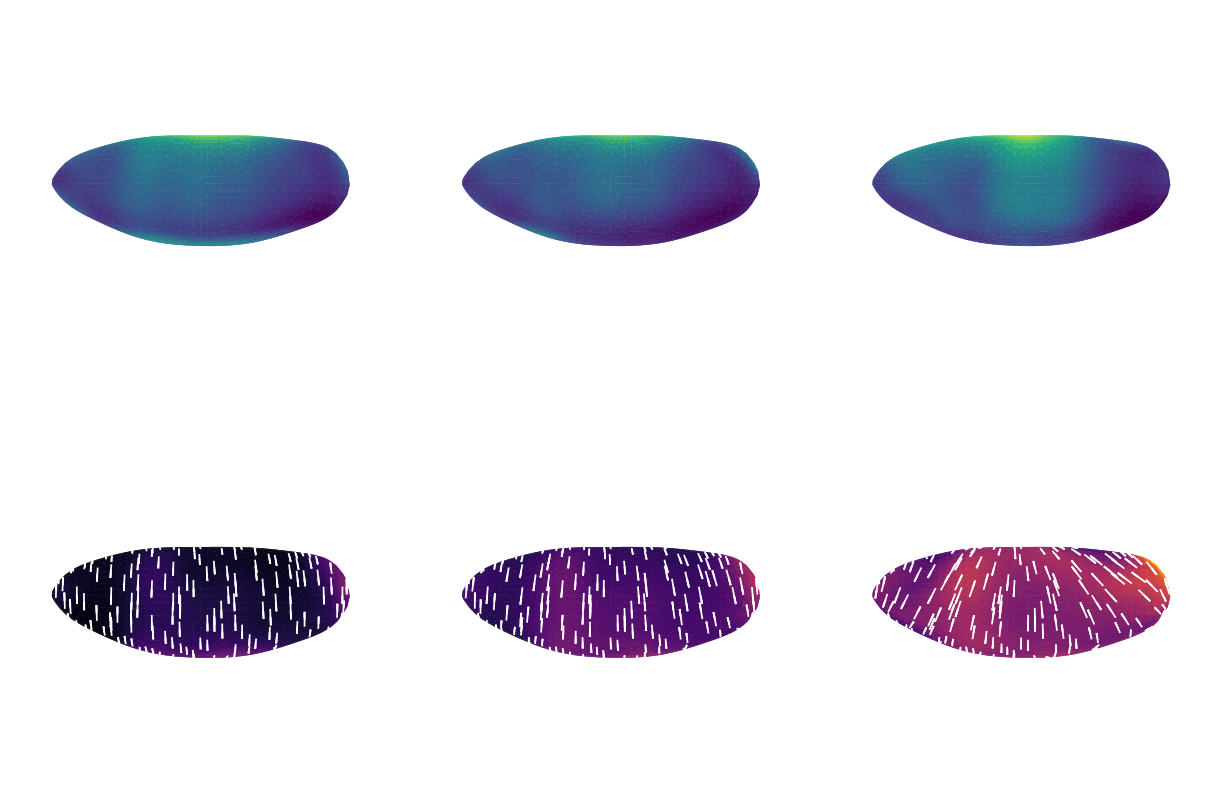

In [8]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import TangentSpaceTransformer
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(mnorm)
    

for i in range(3):
    #plot_tensor3D(ax[0, i], pipe.transform(m0[i*10]), vmin=vmin, vmax=vmax)
    color_3D(ax[0, i], pipe.transform(s0[i*10]))
    plot_tensor3D(ax[1, i], pipe.transform(m[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)

In [21]:
from utils.geometry.geometry_utils import embryo_mesh

verts = embryo_mesh.coordinates()
pix_scale = 0.2619
verts = verts * pix_scale

ptp = np.ptp(verts, axis=0)
radius = np.mean(ptp[:2]/2)

print(f'3D Embryo: radius={radius:.3g}, circumference={2*np.pi*radius:.3g}, length={ptp[2]:.3g} (all in microns)')
print(f'2D Embryo: circumference={dv_max-dv_min:.3g}, length={ap_max-ap_min:.3g} (all in microns)')

3D Embryo: radius=86.7, circumference=545, length=455 (all in microns)
2D Embryo: circumference=534, length=452 (all in microns)
